# Pre-RA Flow PB1 non naive b cells + iGs: Cell type level subclustering

Scaling, dimension reduction, UMAP, freq stats

## Setup

In [22]:
%config Completer.use_jedi = False
import scyan as sy
import os
import glob
import anndata
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scanpy as sc
import scanpy.external as sce
import copy
from concurrent.futures import ProcessPoolExecutor

print(sy.__version__)
print(anndata.__version__)


1.5.1
0.10.6


In [2]:
#### ==== parameter set up ==== ####
# define the working path
panel = "PB1"
# define l1 cell types to subset
cell_types = ['total_b_cells']
# define markers used for clustering
antigens = ["CD10",
"CD19",
"CD20",
"CD21",
"CD27",
"CD38",
"CD71",
"CD24",
"CD319",
"CD274 (PD-L1)",
"CD40",
"CD86",
"CD268 (BR3)",
"CD269 (BCMA)",
"CD85j",
"HLA-DR",
"IgM",
"IgD",
"IgA",
"IgG"
]
data_path='/home/jupyter/projects/pre-ra/flow/raw-data/' + panel + '/labelled-expr/cache/'
fig_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/results/' + panel + '_igPos_non_naive_b_celltype_subsample'  + "/"
proj_name = 'pre-ra_flow_clustering_' + panel
output_path = '/home/jupyter/projects/pre-ra/flow/02-clustering/data/' +panel + '/'

if not os.path.exists(fig_path): os.makedirs(fig_path)
    
if not os.path.exists(output_path): os.makedirs(output_path)

# define scanpy verbose levels
sc.settings.verbosity = 3
sc.settings.figdir = fig_path
sc.settings.n_jobs = -1

## Functions

In [4]:
def read_anndata_files(file_tuples):
    """
    Read Anndata objects from H5AD files and store them in a dictionary with custom names.

    Parameters:
        file_tuples (list of tuples): List of tuples where each tuple contains filename and desired name.

    Returns:
        dict: Dictionary containing Anndata objects with custom names.
    """
    anndata_dict = {}
    for filename, name in file_tuples:
        anndata_obj = anndata.read_h5ad(filename)
        anndata_dict[name] = anndata_obj
    return anndata_dict

In [5]:
def save_anndata_list(anndata_list, filenames):
    """
    Save a list of Anndata objects to separate H5AD files.

    Parameters:
        anndata_list (list): List of Anndata objects to be saved.
        filenames (list): List of filenames to save Anndata objects.

    Returns:
        None
    """
    # zip() combines two lists into a single tuple
    for anndata_obj, filename in zip(adata_downsampled_celltypes, filenames):
        print(adata_downsampled_celltypes[anndata_obj])
        adata_downsampled_celltypes[anndata_obj].write_h5ad(filename)

In [6]:
# make a function to find files
def get_filepaths_with_glob(root_path: str, file_regex: str):
    return glob.glob(os.path.join(root_path, file_regex))

In [23]:
#### parallelized leiden clustering
def run_leiden(adata, resolution, key_added):
    # Make a copy of adata for thread safety
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added, copy=True)
    return adata_clustering.obs
 
def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        # Make deep copies of adata for each task to ensure thread safety
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]
 
    # Assign the results back to the original AnnData object
    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]
 
    return adata

## Read in data

In [7]:
filenames = get_filepaths_with_glob(output_path, "adata_preprocess_unscaled_downsmpl_celltypes_*_igPos*.h5ad")  
#filenames = filenames[0]
filenames

['/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/adata_preprocess_unscaled_downsmpl_celltypes_total_b_cells_PB1_igPos_non_naive_b.h5ad']

In [8]:
cell_types

['total_b_cells']

In [9]:
## turn filenames and cell types into tuple
file_tups = list(zip(filenames, cell_types))
file_tups

[('/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/adata_preprocess_unscaled_downsmpl_celltypes_total_b_cells_PB1_igPos_non_naive_b.h5ad',
  'total_b_cells')]

In [10]:
adata_downsampled_celltypes = read_anndata_files(file_tups)
adata_downsampled_celltypes

{'total_b_cells': AnnData object with n_obs × n_vars = 1854019 × 24
     obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'}

In [11]:
## read in panel df
panel_df = pd.read_csv('/home/jupyter/projects/pre-ra/flow/raw-data/AIFI_flow_' + panel + '_panel_breakdown.csv')
panel_df.tail()

,fcs_colname,antigen,range,minRange,maxRange,marker_class,chn_type,backbone_markers,used_for_clustering
30,Comp-PE-Cy5-A,CD10,4194304,-111.000351,4193244.25,type,fluorchnls,False,Yes
31,Comp-PE-Cy7-A,CD21,4194304,-111.000351,4193244.25,type,fluorchnls,False,Yes
32,Comp-APC-A,CD85j,4194304,-111.000351,4193244.25,type,fluorchnls,False,No
33,Comp-APC-R700-A,CD19,4194304,-111.000351,4193244.25,type,fluorchnls,True,Yes
34,Comp-APC-Cy7-A,CD40,4194304,-111.000351,4193244.25,type,fluorchnls,False,No


## Clustering markers

In [12]:
## validate that clustering antigen markers present in panel df
gating_antigens = panel_df.loc[panel_df['used_for_clustering']=='Yes', 'antigen']

gating_antigens[~gating_antigens.isin(antigens)]

11    CD45
Name: antigen, dtype: object

In [13]:
clust_antigens = [s + '_logicle' for s in antigens]
clust_antigens

['CD10_logicle',
 'CD19_logicle',
 'CD20_logicle',
 'CD21_logicle',
 'CD27_logicle',
 'CD38_logicle',
 'CD71_logicle',
 'CD24_logicle',
 'CD319_logicle',
 'CD274 (PD-L1)_logicle',
 'CD40_logicle',
 'CD86_logicle',
 'CD268 (BR3)_logicle',
 'CD269 (BCMA)_logicle',
 'CD85j_logicle',
 'HLA-DR_logicle',
 'IgM_logicle',
 'IgD_logicle',
 'IgA_logicle',
 'IgG_logicle']

In [14]:
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    sub_adata.var['antigens'] = sub_adata.var.index.str.replace('_logicle', '')

    sub_adata.var[['gating_antigens']] = False
    sub_adata.var.loc[sub_adata.var.index.isin(clust_antigens),'gating_antigens'] = True
    sub_adata.var[['highly_variable']] = sub_adata.var[['gating_antigens']]
    print(sub_adata.var)
    
    adata_downsampled_celltypes[label] = sub_adata
    

Key: total_b_cells
Value: AnnData object with n_obs × n_vars = 1854019 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
                            antigens  gating_antigens  highly_variable
CD38_logicle                    CD38             True             True
CD45_logicle                    CD45            False            False
IgM_logicle                      IgM             True             True
CD56_logicle                    CD56            False            False
CD24_logicle                    CD24             True             True
CD319_logicle                  CD319             True             True
CD20_logicle                    CD20             True 

In [15]:
adata_downsampled_celltypes[cell_types[0]].X

array([[1.4244337, 3.928422 , 3.6371713, ..., 1.6104764, 3.0208206,
        2.6462698],
       [1.8668126, 3.4970255, 1.3001683, ..., 2.0321703, 3.4164834,
        3.0529914],
       [1.4974275, 3.8394883, 1.4379613, ..., 1.6970434, 3.0209033,
        2.4995887],
       ...,
       [2.3373935, 3.967905 , 1.0468955, ..., 1.8699509, 3.0774012,
        2.340522 ],
       [2.7900105, 3.598323 , 3.4494643, ..., 1.3993605, 3.2823694,
        2.7249594],
       [2.5078015, 3.6821737, 3.2091005, ..., 1.2579718, 3.1242175,
        2.7157805]], dtype=float32)

## Scale, PCA, Harmonize, UMAP

Key: total_b_cells
Value: AnnData object with n_obs × n_vars = 1854019 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'


[INFO] (scyan.preprocess) Data will be centered and standardised. This is advised only when using spectral/flow data (if this is not your case, consider running 'asinh_transform' instead of 'auto_logicle_transform').


computing PCA
    on highly variable genes
    with n_comps=19
    finished (0:00:04)


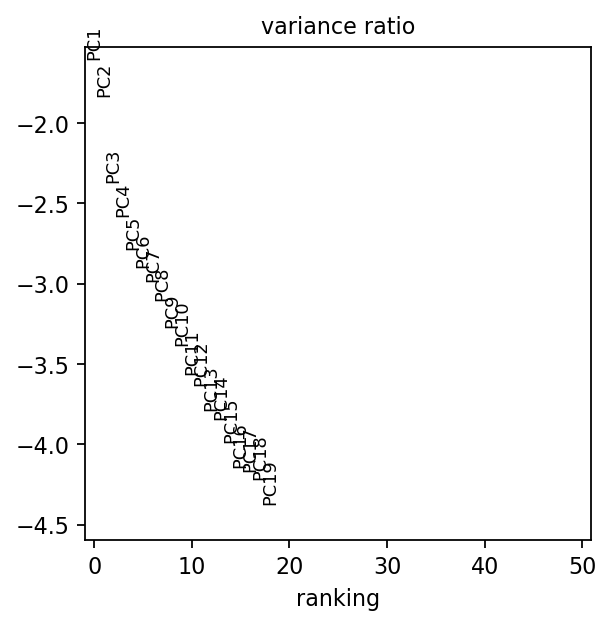

2024-04-12 09:11:22,693 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


In [ ]:
%%time
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    sy.preprocess.scale(sub_adata)
    # stored in .var['highly_variable']
    sc.pp.pca(sub_adata, svd_solver="arpack", use_highly_variable=True)
    sc.pl.pca_variance_ratio(sub_adata, log=True, n_pcs=50, save='pca_var_' +label+'.png') # scanpy generates the filename automatically
    
    # perform batch correction
    sce.pp.harmony_integrate(sub_adata, 'batch', adjusted_basis='X_pca_harmony')
    
    # replace new pca slot
    sub_adata.obsm['X_pca'] = sub_adata.obsm['X_pca_harmony']

    # Perform re-clustering on the subset
    sc.pp.neighbors(sub_adata, n_neighbors=20, use_rep='X_pca_harmony')
    
    # skip leiden until parallelization
    
    sy.tools.umap(sub_adata, obsm='X_pca_harmony',markers=clust_antigens)
    
    
    p1=sy.plot.umap(sub_adata, color=['l1_labels','labels', 'batch','panel'], ncols =2, return_fig = True)
    p1.savefig(fig_path + label + "_umap_labels_batch_panel_" +panel + ".png",
               dpi=400, bbox_inches='tight')
    
    marker_umap  = sc.pl.umap(sub_adata, color=sub_adata.var_names.sort_values(),ncols=6, show=True, return_fig=True, size=.5)
    marker_umap.set_size_inches(18.5, 18.5)
    marker_umap.savefig(fig_path + label + "_umap_expression_labels_corrected_panel_" +panel + ".png")

    # store back to dict
    adata_downsampled_celltypes[label] = sub_adata
    
    

In [18]:
filenames = [output_path + "adata_scaled_harmonized_umap_downsmpl_celltypes_" + cell_type +"_igPos_non_naive_b" "_" + panel + ".h5ad" for cell_type in cell_types]
filenames

['/home/jupyter/projects/pre-ra/flow/02-clustering/data/PB1/adata_scaled_harmonized_umap_downsmpl_celltypes_total_b_cells_igPos_non_naive_b_PB1.h5ad']

In [19]:
save_anndata_list(adata_downsampled_celltypes, filenames)

AnnData object with n_obs × n_vars = 1854019 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


Key: total_b_cells
Value: AnnData object with n_obs × n_vars = 1854019 × 24
    obs: 'Unnamed: 0', 'sample_id', 'cell_id', 'barcode', 'Time', 'SSC-W', 'SSC-H', 'SSC-A', 'FSC-W', 'FSC-H', 'FSC-A', 'SSC-B-W', 'SSC-B-H', 'SSC-B-A', 'Viability_logicle', 'labels', 'batch', 'panel', 'sample.sampleKitGuid', 'l1_labels', 'Status_Xsec', 'Status_Long', 'subject.biologicalSex', 'subject.subjectGuid', 'days_to_conversion', 'age_conv', 'bmi_conv', 'Age2023'
    var: 'antigens', 'gating_antigens', 'highly_variable'
    uns: 'scyan_scaling_stds', 'scyan_scaling_means', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jupyter/envs/libs/scyan/lib/python3.9/site-packages/scyan/plot/_scanpy_plot/umap.py:885: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


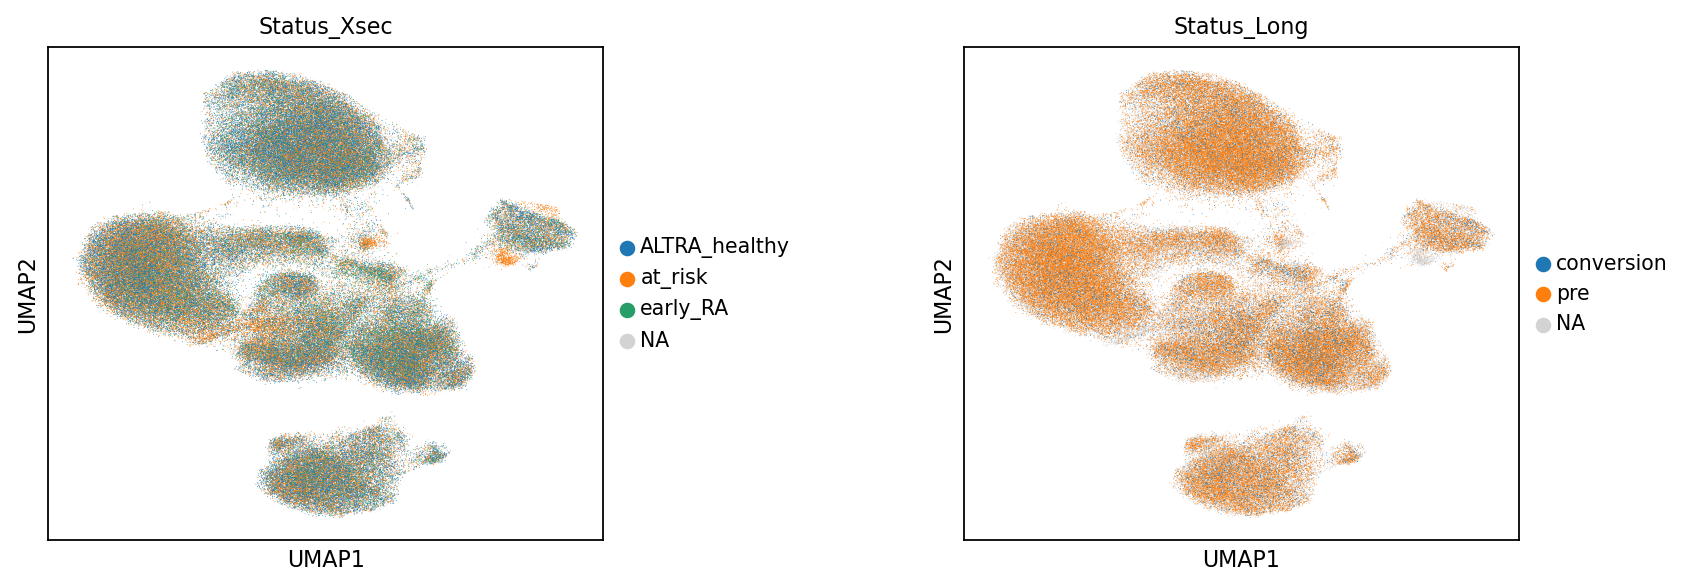

CPU times: user 4.37 s, sys: 211 ms, total: 4.58 s
Wall time: 4.19 s


In [20]:
%%time
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    p1=sy.plot.umap(sub_adata, color=['Status_Xsec', 'Status_Long'], ncols =2, return_fig = True,  wspace=.5)
    p1.savefig(fig_path + label + "_igPos_non_naive_b" + "_umap_status_" +panel + ".png", dpi=400, bbox_inches='tight')
    

## Leiden Clustering

In [25]:
# create separate leiden folder
leiden_fig_path = fig_path +  "/" + panel + "_leiden/"
print(leiden_fig_path)
if not os.path.exists(leiden_fig_path): os.makedirs(leiden_fig_path)

/home/jupyter/projects/pre-ra/flow/02-clustering/results/PB1_igPos_non_naive_b_celltype_subsample//PB1_leiden/


In [ ]:
%%time
for label, sub_adata in adata_downsampled_celltypes.items():
    print("Key:", label)
    print("Value:", sub_adata)
    
    tasks = [(1, "leiden_res_1"),(1.5, "leiden_res_1.5"),(2, "leiden_res_2"),(2.5, "leiden_res_2.5"),(3, "leiden_res_3")]
    leiden_res = ["leiden_res_1", "leiden_res_1.5", "leiden_res_2", "leiden_res_2.5",  "leiden_res_3"]

    sub_adata = run_leiden_parallel(sub_adata, tasks)

    print('leiden clustering completed...')
    
    p1 = sy.plot.umap(sub_adata, color= leiden_res ,return_fig = True, size = .5, ncols = 3,legend_loc="on data")
    p1.savefig(leiden_fig_path + label   + "_umap_leiden_resolutions_" + panel + ".png",  dpi=400, bbox_inches='tight')
    
    for res in leiden_res: 
        p1 = sy.plot.umap(sub_adata, color= res ,return_fig = True, size = .5)
        p1.savefig(leiden_fig_path + label   + "_umap_" + res + "_" +panel + ".png",dpi=400, bbox_inches='tight')
            
    # store back to dict
    adata_downsampled_celltypes[label] = sub_adata